In [409]:
import numpy as np
import scipy.linalg as sla
import numpy.linalg as la
import _547 as lst
import matplotlib.pyplot as plt
import math
import numdifftools as nd
import numdifftools.nd_algopy as nda
%matplotlib inline

In [483]:
L = 0.2 # meter
g = 9.8
k = 2
def f(t,x,u):
    a,b,ad,bd = x
    t1,t2 = u
    return np.array([ad, bd, t1-g*np.cos(a), t2-k*b])

def h(t,x,u):
    a, b, ad, bd = x
    return np.array([ L*np.cos(a)*np.cos(b), L*np.cos(a)*np.sin(b), L*np.sin(a)]) # output only the angle

def sim(f,t,x,u,dt=1e-4):
    j,t_,x_ = 0,[0],[x]
    while j*dt < t:
        t_.append((j+1)*dt)
        x_.append(x_[-1] + dt*f(j*dt,x_[-1],u))
        j += 1
    return np.array(t_),np.array(x_)

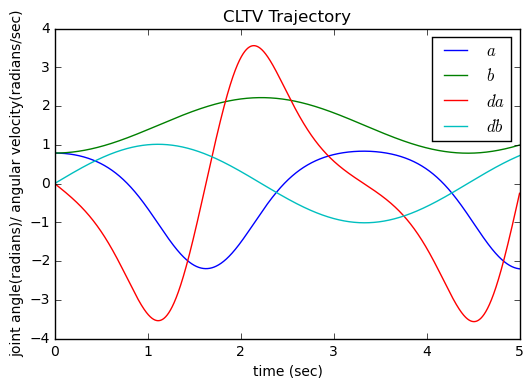

In [501]:
u0 = [0,0]

t1 = 5 # approximately 2 periods
x1 = [math.radians(45), math.radians(45), 0, 0] # "interesting" initial condition

def u0_nq(t):
    return np.asarray([5.0,3.0])

t_,x_ = lst.forward_euler(f=f,t=5,x=np.asarray([math.radians(45 ), math.radians(45), 0.0, 0.0])\
                                    ,ux=u0_nq,dt=0.001)
plt.plot(t_,x_[:,0], label='$a$')
plt.plot(t_,x_[:,1], label='$b$')
plt.plot(t_,x_[:,2], label='$da$')
plt.plot(t_,x_[:,3], label='$db$')
plt.legend()
plt.title('CLTV Trajectory')
plt.xlabel('time (sec)')
plt.ylabel('joint angle(radians)/ angular velocity(radians/sec)')
plt.show(block=True)

# 4. Computation

4.1 perform discretization of your (CLTI) model using a timestep $\Delta > 0$ that is appropriate for your system's dynamics; provide the $\bar{A}$, $\bar{B}$, $\bar{C}$, and $\bar{D}$ matrices for the resulting (DLTI) system, and provide a plot showing agreement between trajectories generated by the (CLTI) and (DLTI) systems.


In [488]:
alpha = math.radians(90)
beta = math.radians(0)
A = np.asarray([[0., 0., 1., 0.],[0., 0., 0., 1.],[g*math.sin(alpha), 0., 0., 0.],\
                [0., -k, 0., 0.]])
B = np.asarray([[0., 0.], [0., 0.], [1., 0.], [0., 1.]])
C = np.asarray([[-L*math.sin(alpha)*math.cos(beta),-L*math.cos(alpha)*math.sin(beta),0.,0.],\
                [-L*math.sin(alpha)*math.sin(beta),-L*math.cos(alpha)*math.cos(beta),0.,0.],\
                [L*math.cos(alpha),0.,0.,0.],\
                [1.,0.,0.,0.],\
                [0.,1.,0.,0.]])
D = np.asarray([[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.]])


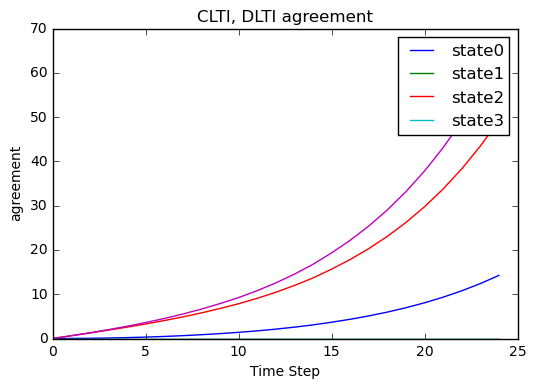

In [505]:
def fLin(t,x,u):
    return np.dot(A,x) + np.dot(B,u)

u = [0,0]
t = 1 # approximately 2 periods
dt = 0.001
x = [math.radians(90), math.radians(0), 0, 0] # "interesting" initial condition

# D
t_d,x_d = sim(f,t,x,u,dt=dt)
# C
def u_c(t,x):
    return [0,0]
t_c,x_c = lst.forward_euler(f=fLin,t=t\
                                ,x=x\
                                ,utx=u_c,dt=dt,return_u=False)
t_temp = 0
s_0 = []
s_1 = []
s_2 = []
s_3 = []
s_list = []
while t_temp < t:
    i = int(t_temp/dt)
    s_0.append(math.fabs(x_c[i][0] - x_d[i][0]));
    s_1.append(math.fabs(x_c[i][1] - x_d[i][1]));
    s_2.append(math.fabs(x_c[i][2] - x_d[i][2]));
    s_3.append(math.fabs(x_c[i][3] - x_d[i][3]));
    s_list.append(s_0[-1]+s_1[-1]+s_2[-1]+s_3[-1])
    t_temp += 4e-2

plt.plot(s_0,label='state0')
plt.plot(s_1,label='state1')
plt.plot(s_2,label='state2')
plt.plot(s_3,label='state3')
plt.plot(s_list)
plt.legend()
plt.title('CLTI, DLTI agreement')
plt.xlabel('Time Step')
plt.ylabel('agreement')
plt.show(block=True)

4.2 specify a quadratic cost function on a finite time horizon for (CLTI) and synthesize a linear time-varying state feedback law by solving the Linear Quadratic Regulation (LQR) problem; discuss whether the performance of the controlled system is desirable and realistic in the context of the application domain; provide formulas showing how you derived the input and include a figure that illustrates the trajectory that results from applying the input.

In [507]:
Aeq = lambda t : A
Beq = lambda t : B
# x in rank 4
Pt = 0.0*np.identity(4)
Q = lambda t : 100.0*np.identity(4)
# u in rank 2
R = lambda t : 1.0*np.identity(2)


In [508]:
# define Q and R matrix and tf,dt
#Q = 100.0*np.identity(4);
#R = 1.0*np.identity(2);
tf = 5.0
dt = 0.001
''''''
'''Function for LQR'''
''''''
# linear system dynamics
def fLin(t,x,u):
    return np.dot(A,x) + np.dot(B,u)
#  equilibrium input function
def uLin(t):
    return np.asarray([0.,0.])
def u0(t):
    return np.asarray([0.0,0.0])

#Define empirical running cost
def runningCost(t,x,u):
    J = 0.0
    i = 0
    t_ = 0
    while t_ < t:
        J += (.5*np.dot(np.dot(x[i,:].T,Q(t_)),x[i,:]) + .5*np.dot(np.dot(u[i,:].T,R(t_)),u[i,:]))*dt
        t_ += dt
        i += 1
    return J

#Define function to generate list of running costs through time
def JtLQR(tf,x,u,dt=dt):
    J = []
    
    t_ = 0.0
    while t_ < tf:
        J.append(runningCost(t_,x,u))
        t_ += dt
    return J

def CT_LQR(A,B,Q,R,Pt,tf,dt=dt):
    t = 0.0
    K =[]
    P =[]
    while t < tf:
        Pi = sla.solve_continuous_are(A(t),B(t),Q(t),R(t));
        K.append(np.dot(la.inv(R(t)), np.dot(B(t).T,Pi)));
        P.append(Pi);
        t += dt;
    K.append(np.dot(la.inv(R(t)), np.dot(B(t).T,Pt)))
    P.append(Pt)
    return np.asarray(K), np.asarray(P)

def tvCTLQR(A,B,Q,R,Pt,tf,dt=dt):
    t_ = 0.0
    K = []
    P = []
    while t_ < tf:
        P_ = sla.solve_continuous_are(A(t_),B(t_),Q(t_),R(t_))
        K_ = np.dot(la.inv(R(t_)), np.dot(B(t_).T,P_))
        K.append(K_)
        P.append(P_)
        t_ += dt
    K_ = np.dot(la.inv(R(t_)), np.dot(B(t_).T,Pt))
    K.append(K_)
    P.append(Pt)
    return np.asarray(K),np.asarray(P)

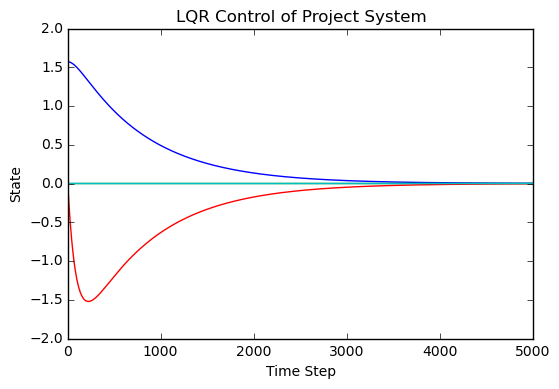

In [509]:
xeq = np.asarray([math.radians(90), math.radians(0), 0.0, 0.0])
K,P = tvCTLQR(Aeq,Beq,Q,R,Pt,tf,dt=dt);
def uOpt(t,x):
    return -np.dot(K[int(t/dt)],x)
t_LQR1,x_LQR1,u_LQR1 = lst.forward_euler(f=fLin,t=tf\
                                         ,x= xeq\
                                         ,utx=uOpt,dt=dt,return_u=True)

plt.plot(x_LQR1[:,0])
plt.plot(x_LQR1[:,1])
plt.plot(x_LQR1[:,2])
plt.plot(x_LQR1[:,3])
plt.title('LQR Control of Project System')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.show(block=True)

In [510]:
u_LQR1 = np.vstack((u_LQR1,[0.0,0.0]))
print runningCost(tf,x_LQR1,u_LQR1)
print .5*np.dot(np.dot(xeq.T,P[0]),xeq)

210.102035738
209.859912378


4.3 use steepest descent to synthesize optimal control signals for at least one nonzero initial condition and compare the result with that obtained from 4.2.

Lets create a perturbation to make an non equilibrium initial condition.

In [426]:
tf = 3.0
dt = .1

x0 = np.asarray([math.radians(90 ), math.radians(0), 0.0, 0.0])

t_0,x_0,u_0 = lst.forward_euler(f=fLin,t=tf,x=x0,ut=u0,dt=dt,return_u=True)
u_0 = np.vstack((u_0,[0.0,0.0]))

def LQRPerturbations(perturbations):
    trials = []
    index = 0
    for perturbation in perturbations:
        print index
        index += 1
        K,P = tvCTLQR(Aeq,Beq,Q,R,Pt,tf,dt=dt)
        p_x = x0 + perturbation;
        t_LQR,x_LQR,u_LQR = lst.forward_euler(f=fLin,t=tf,x=p_x,utx=uOpt,dt=dt,return_u=True)
        trials.append((p_x,x_LQR,u_LQR,JtLQR(tf,x_LQR,u_LQR,dt=dt),P))
    return trials

# create perturbations
perturbs = [np.asarray([math.radians(5),0.0,0.0,0.0]),
            np.asarray([0.0,math.radians(5),0.0,0.0]),
            np.asarray([0.0,0.0,2.0,0.0]),
            np.asarray([0.0,0.0,0.0,2.0])]

LQRtrials = LQRPerturbations(perturbs)

0
1
2
3


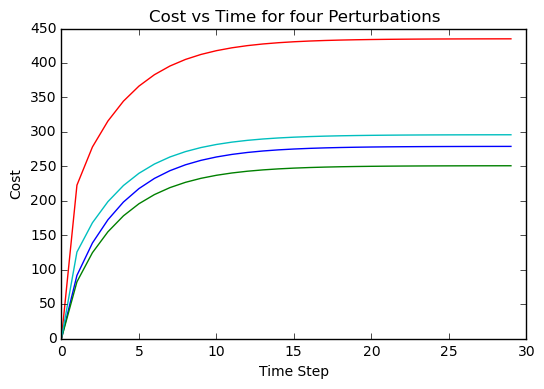

In [267]:
for i in range(4):
    plt.plot(LQRtrials[i][3][:])
plt.title('Cost vs Time for four Perturbations')
plt.xlabel('Time Step')
plt.ylabel('Cost')
plt.show(block=True)

In [275]:
''''''
'''functions for steepest descent'''
''''''
def Ju(u,t_f=tf,dt=dt,
       xEq=np.asarray([math.radians(90), math.radians(0), 0.0, 0.0])
       ,x0=x0,uEq=np.asarray([0.0,0.0])):
    uT = lambda t : u[int(t/dt),:]
    P = 0.0*np.identity(4)
    Q = 100.0*np.identity(4)
    R = 1.0*np.identity(2)
    t = 0
    t_,x_ = lst.forward_euler(f=fLin,t=t_f,x=x0,ut=uT,dt=dt)
    integral = np.dot(np.dot((x_[-1,:] - xEq).T,P),x_[-1,:] - xEq)
    while t < t_f:
        i = int(t/dt)
        integral += (np.dot(np.dot((x_[i,:] - xEq).T,Q),x_[i,:] - xEq) + np.dot(np.dot((u[i,:]-uEq).T,R),(u[i,:]-uEq)))*dt
        t += dt
    return integral

def jacobian(g,X,n=None):
    if not n:
        n = len(X)
    h = np.finfo(float).eps**(1.0/4.0)
    e = np.identity(n)
    D = []
    for j in range(n):
        D.append((.5/h)*(g(X+h*e[j]) - g(X-h*e[j])))
    return np.array(D).T

def jacobianTrj(g,X,n=None,m=None):
    if not n:
        m_,n = X.shape
    if not m:
        m,n_ = X.shape
    h = np.finfo(float).eps**(1.0/4.0)
    e = np.identity(m)
    D = []
    for i in range(n):
        for j in range(m):
            #print (i,j)
            E = np.zeros((m,n))
            E[:,i] = e[j]
            D.append((.5/h)*(g(X+h*E) - g(X-h*E)))
    return np.array(D).T

def steepestDescent(J,x,DJ=None,alpha=.0001):
    if not DJ:
        DJ = jacobian
    diff = -1.0
    while diff < 0:
        grad = DJ(J,x)
        x_ = x
        x = x - alpha*grad
        diff = J(x)-J(x_)
    return J(x),x

def steepestDescentTrj(J,x,DJ=None,alpha=.0001,maxIter=30000):
    if not DJ:
        DJ = jacobianTrj
    diff = 1.0
    K = 0
    #Use norm of difference between costs as termination condition
    #There are other valid termination conditions, e.g. norm(DJ) > lambda
    #Also stop if we reach a certain number of max iterations,
    #because we don't want to wait all day.
    while la.norm(diff) > 1e-1 and K < maxIter:
        grad = DJ(J,x)
        m,n = x.shape
        gradMat = np.zeros((m,n))
        for i in range(n):
            gradMat[:,i] = grad[i*m:(i+1)*m]
        x_ = x
        x = x - alpha*gradMat
        diff = J(x)-J(x_)
        K += 1
    return J(x),x


def NumPerturbations(perturbs):
    trials = []
    for perturb in perturbs:
        xPerturb = x0 + perturb
        Jperturb = lambda u : Ju(u,x0=xPerturb) #Define "J~" passing in perturbed initial state
        DJt = lambda x : jacobianTrj(Jperturb,x)
        D2Jt = lambda x : jacobianTrj(DJt,x)
        costD2J = D2Jt(u_0) #Calculate Hessian
        costD2Jeigs,_ = la.eig(costD2J)
        alpha = .95*2.0/max(costD2Jeigs) #Calculate alpha based on Hessian eigenvalue condition
        J_Num,u_Num = steepestDescentTrj(Jperturb,u_0,DJ=jacobianTrj,alpha=alpha)
        print J_Num
        uNumFunc = lambda t : u_Num[int(t/dt),:]
        t_Num,x_Num = lst.forward_euler(f=fLin,t=tf,x=xPerturb,ut=uNumFunc,dt=dt)
        trials.append((perturb,x_Num,u_Num))
    return trials

In [230]:
NumTrials = NumPerturbations(perturbs)

(867.663779175+0j)
835.378264531
1072.28125833
1919.48480967


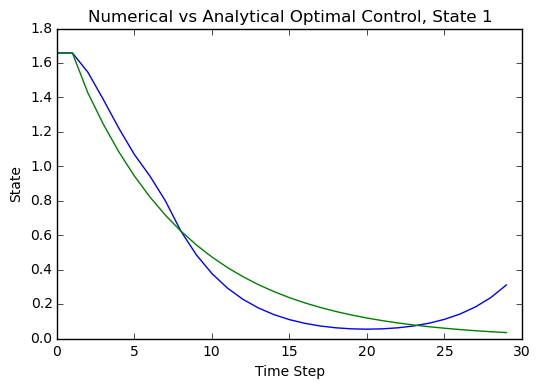

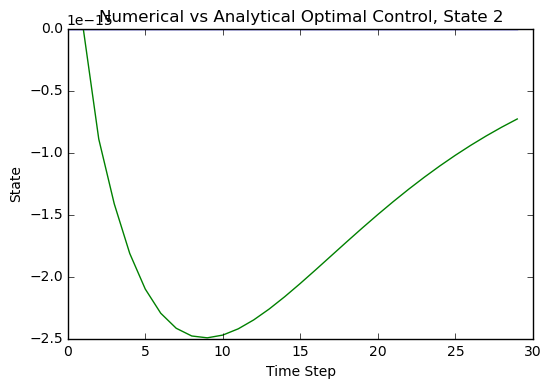

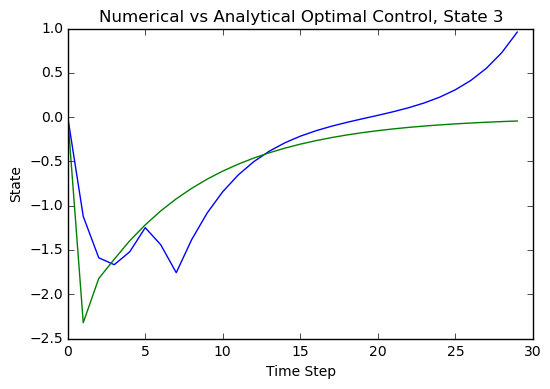

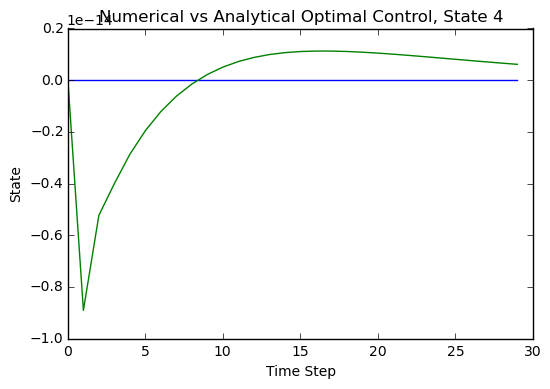

In [231]:
plt.plot(NumTrials[0][1][:,0])
plt.plot(LQRtrials[0][1][:,0])
plt.title('Numerical vs Analytical Optimal Control, State 1')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.show()
plt.plot(NumTrials[0][1][:,1])
plt.plot(LQRtrials[0][1][:,1])
plt.title('Numerical vs Analytical Optimal Control, State 2')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.show()
plt.plot(NumTrials[0][1][:,2])
plt.plot(LQRtrials[0][1][:,2])
plt.title('Numerical vs Analytical Optimal Control, State 3')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.show()
plt.plot(NumTrials[0][1][:,3])
plt.plot(LQRtrials[0][1][:,3])
plt.title('Numerical vs Analytical Optimal Control, State 4')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.show()

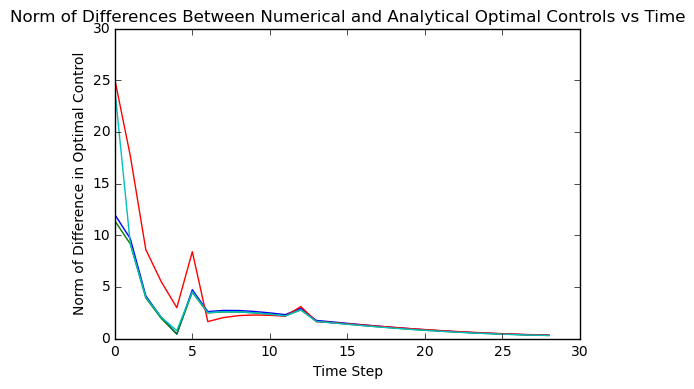

In [232]:
normControlDiff = np.zeros((29,4))
for j in range(len(normControlDiff[0,:])):
    for i in range(len(normControlDiff[:,0])):
        normControlDiff[i,j] = la.norm(NumTrials[j][2][i,:] - LQRtrials[j][2][i,:])
        
plt.plot(normControlDiff[:,0])
plt.plot(normControlDiff[:,1])
plt.plot(normControlDiff[:,2])
plt.plot(normControlDiff[:,3])
plt.title('Norm of Differences Between Numerical and Analytical Optimal Controls vs Time')
plt.ylabel('Norm of Difference in Optimal Control')
plt.xlabel('Time Step')
plt.show()

In [531]:
''''''
'''Nonlinear Trj'''
''''''
tf = 3.0
dt = .01

alpha = math.radians(90)
beta = math.radians(0)

Aeq = lambda t : A
Beq = lambda t : B
# x in rank 4
Pt = 0.0*np.identity(4)
Q = lambda t : 100.0*np.identity(4)
# u in rank 2
R = lambda t : 1.0*np.identity(2)

def u0_nq(t):
    return np.asarray([5.0,3.0])

t_nonEq,x_nonEq = lst.forward_euler(f=f,t=tf,x=np.asarray([math.radians(45 ), math.radians(45), 0.0, 0.0])\
                                    ,ux=u0_nq,dt=dt)

def AnonEq(t,xTraj=x_nonEq):
    #x1,x2,x3,x4 = xTraj[int(t/dt)] #Unpack state from calculated nonlinear trajectory at time index t
    return np.array([[0.0,0.0,1.0,0],
            [0.0,0.0,0.0,1.0],
            [g*math.sin(alpha),0.0,0.0,0.0],
            [0.0,-k,0.0,0.0]])

def fLinNonEq(t,x,u):
    return np.dot(AnonEq(t),x) + np.dot(B,u)


xLin_nonEq = np.zeros((int(tf/dt),4))
def JuNonEq(u,t_f=tf,dt=dt,xEq=xLin_nonEq,x0=x0,uEq=np.asarray([0.0,0.0])):
    uT = lambda t : u[int(t/dt),:]
    P = 0.0*np.identity(4)
    Q = 100.0*np.identity(4)
    R = 1.0*np.identity(2)
    t = 0
    t_,x_ = lst.forward_euler(f=fLinNonEq,t=t_f,x=x0,ut=uT,dt=dt)
    integral = np.dot(np.dot((x_[-1,:] - xEq[-1,:]).T,P),x_[-1,:] - xEq[-1,:])
    while t < t_f:
        i = int(t/dt)
        integral += (np.dot(np.dot((x_[i,:] - xEq[i,:]).T,Q),x_[i,:] - xEq[i,:]) + np.dot(np.dot((u[i,:]-uEq).T,R),(u[i,:]-uEq)))*dt
        t += dt
    return integral

def LQRNonEqPerturbations(perturbations):
    trials = []
    for perturbation in perturbations:
        K,P = CT_LQR(AnonEq,Beq,Q,R,Pt,tf,dt=dt)
        def uOpt(t,x):
            return -np.dot(K[int(t/dt)],x)
        p_x = perturbation + x0_nq
        t_LQR,x_LQR,u_LQR = lst.forward_euler(f=fLinNonEq,t=tf,x=p_x,utx = uOpt,dt=dt,return_u=True)
        trials.append((p_x,x_LQR,u_LQR,JtLQR(tf,x_LQR,u_LQR,dt=dt)))
    return trials

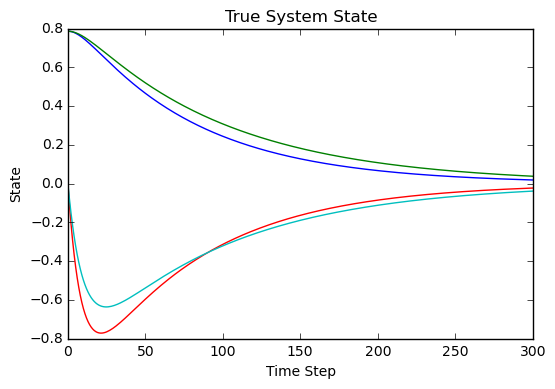

In [532]:
'''add perturbation
LQRNonEqtrials = LQRNonEqPerturbations(perturbs)
for i in range(4):
    plt.plot(LQRNonEqtrials[i][3][:])
plt.title('Cost vs Time for Six Perturbations, Non-Equilibrium Traj.')
plt.xlabel('Time Step')
plt.ylabel('Cost')
plt.show()'''


xeq = np.asarray([math.radians(45), math.radians(45), 0.0, 0.0])
K,P = tvCTLQR(Aeq,Beq,Q,R,Pt,tf,dt=dt);
def uOpt(t,x):
    return -np.dot(K[int(t/dt)],x)
t_LQR,x_LQR,u_LQR = lst.forward_euler(f=fLin,t=tf\
                                         ,x= xeq\
                                         ,utx=uOpt,dt=dt,return_u=True)


'''K,P = CT_LQR(AnonEq,Beq,Q,R,Pt,tf,dt=dt)
def uOpt(t,x):
    return -np.dot(K[int(t/dt)],x)
p_x = x0_nq
t_LQR,x_LQR,u_LQR = lst.forward_euler(f=fLinNonEq,t=tf,x=p_x,utx = uOpt,dt=dt,return_u=True)
'''
genTrj = (p_x,x_LQR,u_LQR,JtLQR(tf,x_LQR,u_LQR,dt=dt))
plt.plot(genTrj[1][:,0])
plt.plot(genTrj[1][:,1])
plt.plot(genTrj[1][:,2])
plt.plot(genTrj[1][:,3])
plt.title('True System State')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.show()

In [533]:
# disturbance simulation
def calc_sp_mean(W,k):
    count = 0
    sm = np.zeros((1, k))
    for w in W:
        count = count + 1
        sm = sm + w
    return sm/count

def calc_cov(W, k):
    count = 0
    sm = np.zeros((k, k))
    w_bar = calc_sp_mean(W, k)
    for w in W:
        count = count + 1
        tw = w-w_bar
        temp = np.dot(np.transpose(tw),(tw))
        sm = sm + temp
        
    return sm/(count), w_bar

def standardGaussianSamples(k, N):
    mean = np.zeros(k)
    cov = np.identity(k)
    W = np.random.multivariate_normal(mean, cov,N)
    print calc_cov(W, k)

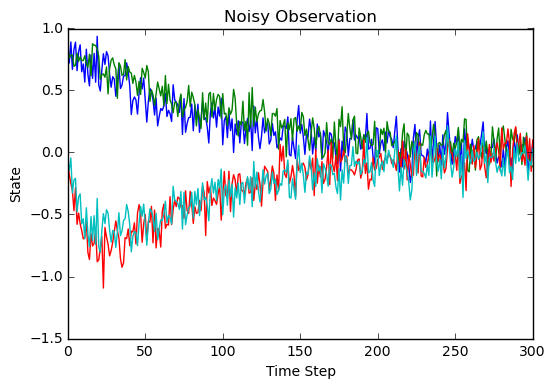

In [534]:
'''add noise'''
from random import randint
size = len(genTrj[1][:,0])
cov = [[1]]
genNsyTrj = genTrj
for i in range(size):
    
    mu = genTrj[1][i,:]
    sigma = np.asarray([[0.01,0.,0.,0.01], [0.,0.01,0.,0.],[0.,0.,0.01,0.],[0.01,0.,0.,0.01]])
    genNsyTrj[1][i,:] = np.random.multivariate_normal(mu,sigma,1)
    
    '''genNsyTrj[1][i,0] = np.random.normal(genTrj[1][i,0], 0.05, 1)
    genNsyTrj[1][i,1] = np.random.normal(genTrj[1][i,1], 0.05, 1)
    genNsyTrj[1][i,2] = np.random.normal(genTrj[1][i,2], 0.05, 1)
    genNsyTrj[1][i,3] = np.random.normal(genTrj[1][i,3], 0.05, 1)'''

plt.plot(genNsyTrj[1][:,0])
plt.plot(genNsyTrj[1][:,1])
plt.plot(genNsyTrj[1][:,2])
plt.plot(genNsyTrj[1][:,3])
plt.title('Noisy Observation')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.show()

In [536]:
def kalman_filter(x0,P0,A,B,u,F,Q,H,R,t_,z_):
    x_ = [x0]; P_ = [P0]
    for t in range(len(t_)-1):
        xt_ = np.dot(A,x_[-1]) + np.dot(B,u[t])
        if isinstance(Q,float): #Optional if statement if there might be a scalar Q in your system
            Pt_ = np.dot(A,np.dot(P_[-1],A.T)) + Q*np.dot(F,np.transpose(F))
        else:
            Pt_ = np.dot(A,np.dot(P_[-1],np.transpose(A))) + np.dot(F,np.dot(Q,np.transpose(F)))
        
        S = np.dot(np.dot(H, Pt_), H.T) + R
        if not S.shape: #Optional if statement if there might be a scalar R in your system
            K = (1.0/S)*np.dot(Pt_,H.T)
            xt = xt_ + (z_[t] - np.dot(H, xt_))*K.reshape(xt_.shape)
        else:
            K = np.dot(np.dot(Pt_, np.transpose(H)), la.inv(S))
            xt = xt_ + np.dot(K,(z_[t] - np.dot(H, xt_)))
        Pt = np.dot(np.identity(np.shape(Pt_)[0]) - np.dot(K,H),Pt_)
        x_.append(xt)
        P_.append(Pt)
    return np.asarray(x_),np.asarray(P_)

In [537]:

Sigma0 = [[1.,0.,0.,0.],[0.,1.,0.,0.],[0.,0,1.,0.],[0.,0.,0.,1.]]

# n = 4, m = 2, k = 4, l = 4?

#x0 - n x 1 array; initial state mean
x0 = np.asarray([math.radians(45), math.radians(45), 0.0, 0.0])
#P0 - n x n array; initial state covariance
P0 = np.array(Sigma0)
#A - func : t -> n x n array; state transition
A = A
#B - func : t -> n x m array; control input matrix
B = B
#u - func : t -> m x 1 array; control input
#u = np.array([[0]])
#F - func : t -> n x k array; disturbance matrix
F = np.asarray([[1.,0.,0.,0.], [0.,1.,0.,0.],[0.,0.,1.,0.],[0.,0.,0.,1.]])
#Q - func : t -> k x k array; disturbance covariance
Q = np.asarray([[1.,0.,0.,0.], [0.,1.,0.,0.],[0.,0.,1.,0.],[0.,0.,0.,1.]])
#H - func : t -> l x n array; measurement matrix
H = np.asarray([[1.,0.,0.,0.], [0.,1.,0.,0.],[0.,0.,1.,0.],[0.,0.,0.,1.]])
#R - func : t -> l x l array; measurement covariance
R = np.asarray([[0.01,0.,0.,0.01], [0.,0.01,0.,0.],[0.,0.,0.01,0.],[0.01,0.,0.,0.01]])
#D
D = np.asarray(0.0)
delta = .1

Ad = sla.expm(delta*A)
Bd = np.dot(np.dot(np.dot(Ad,(np.identity(4) - la.inv(Ad))),la.inv(A)),B)
Fd = np.dot(np.dot(np.dot(Ad,(np.identity(4) - la.inv(Ad))),la.inv(A)),F)

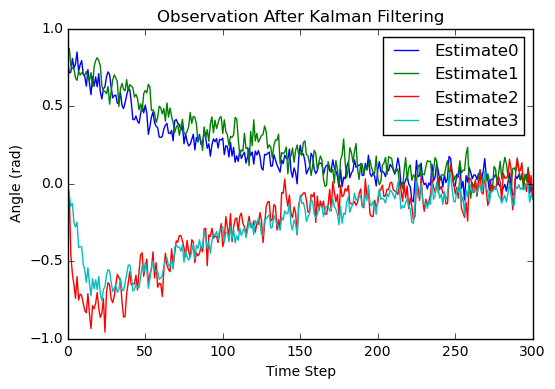

In [538]:
u_ = genNsyTrj[2]
t_ = t_LQR
z_ = genNsyTrj[1]
xh,p = kalman_filter(x0,P0,Ad,Bd,u_,Fd,Q,H,R,t_,z_)
plt.plot(xh[:,0],label='Estimate0')
plt.plot(xh[:,1],label='Estimate1')
plt.plot(xh[:,2],label='Estimate2')
plt.plot(xh[:,3],label='Estimate3')
plt.title('Observation After Kalman Filtering')
#plt.plot(z_[:],label='Observation')
plt.ylabel('Angle (rad)')
plt.xlabel('Time Step')
plt.legend()
plt.show()

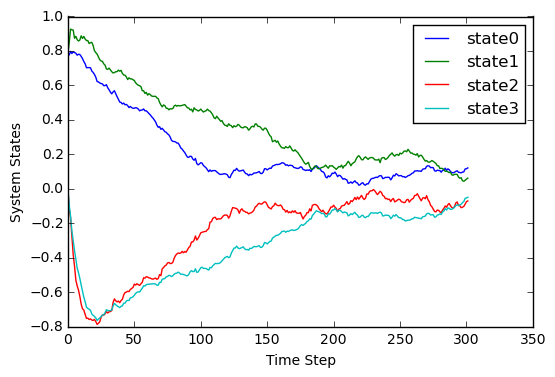

In [550]:
tf = 3.0
dt = .01

def uOpt(t,x):
    return -np.dot(K[int(t/dt)],x)

def kalman_filter_cl(x_,P_,A,B,u,F,Q,H,R,z_):
    xt_ = np.dot(A,x_[-1]) + np.dot(B,u[-1])
    if isinstance(Q,float): #Optional if statement if there might be a scalar Q in your system
        Pt_ = np.dot(A,np.dot(P_[-1],A.T)) + Q*np.dot(F,np.transpose(F))
    else:
        Pt_ = np.dot(A,np.dot(P_[-1],np.transpose(A))) + np.dot(F,np.dot(Q,np.transpose(F)))

    S = np.dot(np.dot(H, Pt_), H.T) + R
    if not S.shape: #Optional if statement if there might be a scalar R in your system
        K = (1.0/S)*np.dot(Pt_,H.T)
        xt = xt_ + (z_[-1][0] - np.dot(H, xt_))*K.reshape(xt_.shape)
    else:
        K = np.dot(np.dot(Pt_, np.transpose(H)), la.inv(S))
        xt = xt_ + np.dot(K,(z_[-1][0] - np.dot(H, xt_)))
    Pt = np.dot(np.identity(np.shape(Pt_)[0]) - np.dot(K,H),Pt_)
    return xt, Pt

Sigma0 = np.asarray([[1.,0.,0.,0.],[0.,1.,0.,0.],[0.,0,1.,0.],[0.,0.,0.,1.]])
sigma = np.asarray([[0.01,0.,0.,0.01], [0.,0.01,0.,0.],[0.,0.,0.01,0.],[0.01,0.,0.,0.01]])
# n = 4, m = 2, k = 4, l = 4?
#x0 - n x 1 array; initial state mean
x0 = np.asarray([math.radians(45), math.radians(45), 0.0, 0.0])
#P0 - n x n array; initial state covariance
P0 = Sigma0
#A - func : t -> n x n array; state transition
A = A
#B - func : t -> n x m array; control input matrix
B = B
#F - func : t -> n x k array; disturbance matrix
F = np.asarray([[1.,0.,0.,0.], [0.,1.,0.,0.],[0.,0.,1.,0.],[0.,0.,0.,1.]])
#Q - func : t -> k x k array; disturbance covariance
Q = Sigma0
#H - func : t -> l x n array; measurement matrix
H = np.asarray([[1.,0.,0.,0.], [0.,1.,0.,0.],[0.,0.,1.,0.],[0.,0.,0.,1.]])
#R - func : t -> l x l array; measurement covariance
R = sigma
#D
D = np.asarray(0.0)

#Qeq = lambda t : Q
#Req = lambda t : R

delta = dt
Ad = sla.expm(delta*A)
Bd = np.dot(np.dot(np.dot(Ad,(np.identity(4) - la.inv(Ad))),la.inv(A)),B)
Fd = np.dot(np.dot(np.dot(Ad,(np.identity(4) - la.inv(Ad))),la.inv(A)),F)

def fLin(t,x,u):
    return np.dot(A,x) + np.dot(B,u)

def tvCTLQR_cl(A,B,Q,R,t):
    P_ = sla.solve_continuous_are(A(t),B(t),Q(t),R(t))
    K_ = np.dot(la.inv(R(t)), np.dot(B(t).T,P_))
    return K_, P_
    

# x in rank 4
Pt_lqr = 0.0*np.identity(4)
Qeq = lambda t : 100.0*np.identity(4)
# u in rank 2
Req = lambda t : 1.0*np.identity(2)


t_temp = 0
x_n = [np.asarray([math.radians(45), math.radians(45), 0.0, 0.0])] 
x_ = [np.asarray([math.radians(45), math.radians(45), 0.0, 0.0])]
P_ = [P0];
z_ = [];
u_ = [np.asarray([0.0, 0.0])];
while t_temp < tf:
    i = int(t_temp/dt)
    # noise 
    mu = x_n[-1]
    z_.append(np.random.multivariate_normal(mu,sigma,1))
    
    # Kalman Filter
    xt, Pt = kalman_filter_cl(x_,P_,Ad,Bd,u_,Fd,Q,H,R,z_)
    x_.append(xt)
    P_.append(Pt)
    
    # LQR
    K,pp = tvCTLQR_cl(Aeq,Beq,Qeq,Req,t_temp)
    u_.append(-np.dot(K,x_[-1]))
    
    # system 
    _x,_u =x_[-1],u_[-1]
    dx = fLin(t_temp,_x,_u) * dt
    x_n.append(_x + dx)
    
    t_temp += dt

state0 = []
state1 = []
state2 = []
state3 = []
state4 = []
for state in x_n:
    state0.append(state[0])
    state1.append(state[1])
    state2.append(state[2])
    state3.append(state[3])
    
plt.plot(state0,label='state0')
plt.plot(state1,label='state1')
plt.plot(state2,label='state2')
plt.plot(state3,label='state3')
#plt.plot(z_[:],label='Observation')
plt.ylabel('System States')
plt.xlabel('Time Step')
plt.legend()
plt.show()

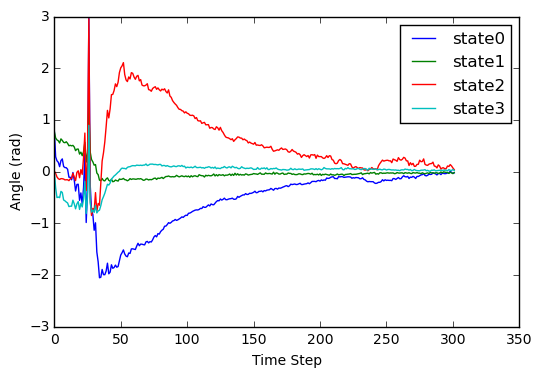

In [563]:
tf = 3.0
dt = .01

def uOpt(t,x):
    return -np.dot(K[int(t/dt)],x)

def kalman_filter_cl(x_,P_,A,B,u,F,Q,H,R,z_):
    xt_ = np.dot(A,x_[-1]) + np.dot(B,u[-1])
    if isinstance(Q,float): #Optional if statement if there might be a scalar Q in your system
        Pt_ = np.dot(A,np.dot(P_[-1],A.T)) + Q*np.dot(F,np.transpose(F))
    else:
        Pt_ = np.dot(A,np.dot(P_[-1],np.transpose(A))) + np.dot(F,np.dot(Q,np.transpose(F)))

    S = np.dot(np.dot(H, Pt_), H.T) + R
    if not S.shape: #Optional if statement if there might be a scalar R in your system
        K = (1.0/S)*np.dot(Pt_,H.T)
        xt = xt_ + (z_[-1][0] - np.dot(H, xt_))*K.reshape(xt_.shape)
    else:
        K = np.dot(np.dot(Pt_, np.transpose(H)), la.inv(S))
        xt = xt_ + np.dot(K,(z_[-1][0] - np.dot(H, xt_)))
    Pt = np.dot(np.identity(np.shape(Pt_)[0]) - np.dot(K,H),Pt_)
    return xt, Pt

Sigma0 = [[1.,0.,0.,0.],[0.,1.,0.,0.],[0.,0,1.,0.],[0.,0.,0.,1.]]
sigma = np.asarray([[0.05,0.01,0.,0.03], [0.01,0.01,0.,0.],[0.,0.,0.01,0.1],[0.03,0.,0.01,0.05]])
# n = 4, m = 2, k = 4, l = 4?
#x0 - n x 1 array; initial state mean
x0 = np.asarray([math.radians(45), math.radians(45), 0.0, 0.0])
#P0 - n x n array; initial state covariance
P0 = np.array(Sigma0)
#A - func : t -> n x n array; state transition
A = A
#B - func : t -> n x m array; control input matrix
B = B
#F - func : t -> n x k array; disturbance matrix
F = np.asarray([[1.,0.,0.,0.], [0.,1.,0.,0.],[0.,0.,1.,0.],[0.,0.,0.,1.]])
#Q - func : t -> k x k array; disturbance covariance
Q = np.asarray([[0.0001,0.,0.,0.], [0.,0.0001,0.,0.],[0.,0.,0.0001,0.],[0.,0.,0.,0.0001]])
#H - func : t -> l x n array; measurement matrix
H = np.asarray([[1.,0.,0.,0.], [0.,1.,0.,0.],[0.,0.,1.,0.],[0.,0.,0.,1.]])
#R - func : t -> l x l array; measurement covariance
R = sigma
#D
D = np.asarray(0.0)

#Qeq = lambda t : Q
#Req = lambda t : R

delta = dt
Ad = sla.expm(delta*A)
Bd = np.dot(np.dot(np.dot(Ad,(np.identity(4) - la.inv(Ad))),la.inv(A)),B)
Fd = np.dot(np.dot(np.dot(Ad,(np.identity(4) - la.inv(Ad))),la.inv(A)),F)

def fLin(t,x,u):
    return np.dot(A,x) + np.dot(B,u)

def tvCTLQR_cl(A,B,Q,R,t):
    P_ = sla.solve_continuous_are(A(t),B(t),Q(t),R(t))
    K_ = np.dot(la.inv(R(t)), np.dot(B(t).T,P_))
    return K_, P_
    

# x in rank 4
Pt_lqr = 0.0*np.identity(4)
Qeq = lambda t : 100.0*np.identity(4)
# u in rank 2
Req = lambda t : 1.0*np.identity(2)



t_temp = 0
x_n = [np.asarray([math.radians(45), math.radians(45), 0.0, 0.0])] 
x_ = [np.asarray([math.radians(45), math.radians(45), 0.0, 0.0])]
P_ = [P0];
z_ = [];
u_ = [np.asarray([0.0, 0.0])];
while t_temp < tf:
    i = int(t_temp/dt)
    
    #disturbance
    x_n[-1] += np.random.multivariate_normal(np.asarray([0,0,0,0]),Q,1)[0]
    
    # noise 
    mu = x_n[-1]
    z_.append(np.random.multivariate_normal(mu,sigma,1))
    
    # Kalman Filter
    xt, Pt = kalman_filter_cl(x_,P_,Ad,Bd,u_,Fd,Q,H,R,z_)
    x_.append(xt)
    P_.append(Pt)
    
    # LQR
    K,pp = tvCTLQR_cl(Aeq,Beq,Qeq,Req,t_temp)
    u_.append(-np.dot(K,x_[-1]))
    
    # system 
    _x,_u =x_[-1],u_[-1]
    dx = fLin(t_temp,_x,_u) * dt
    x_n.append(_x + dx)
    
    t_temp += dt

state0 = []
state1 = []
state2 = []
state3 = []
state4 = []
for state in x_n:
    state0.append(state[0])
    state1.append(state[1])
    state2.append(state[2])
    state3.append(state[3])
    
plt.plot(state0,label='state0')
plt.plot(state1,label='state1')
plt.plot(state2,label='state2')
plt.plot(state3,label='state3')
#plt.plot(z_[:],label='Observation')
plt.ylabel('Angle (rad)')
plt.xlabel('Time Step')
plt.legend()
plt.show()